In [158]:
import datetime as dt
import itertools
import os
import pickle
from dataclasses import dataclass
from pathlib import Path

import git
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyodbc
import seaborn as sns; sns.set_theme(style='white')
from fbprophet import Prophet
from sktime.forecasting.model_selection import temporal_train_test_split
from sqlalchemy import create_engine
from tqdm.notebook import tqdm

REPO_ROOT = Path(git.Repo('.', search_parent_directories=True).working_tree_dir).absolute()
OCCUPANCY_FEATHER_PATH = REPO_ROOT / 'data' / 'raw' / 'parking_zone_occupancy_aggr.feather'

%cd -q $REPO_ROOT

import app.keeper_of_the_state
from app.constants import DAY_OF_WEEK
from app.constants import UNENFORCED_DAYS
from app.data_formats import APIPredictionRequest
from app.model import ModelFeatures, ParkingAvailabilityModel


def load_occupancy_dataset(remove_inactive_timeslots=True):
    if OCCUPANCY_FEATHER_PATH.exists():
        occupancy = pd.read_feather(OCCUPANCY_FEATHER_PATH)
    else:
        occupancy = pd.read_sql_query(
            r'''
                SELECT *
                FROM [dbo].[parking_zone_occupancy_aggr]
                ORDER BY zone_name, semihour
            ''',
            'mssql+pyodbc://{user}:{password}@{server_url}:{server_port}/{database}?driver={driver}'.format(
                user='padmin',
                password=os.getenv('SQL_SERVER_PASSWORD'),
                server_url='dev-data-science-parking-prediction.crrvm15jali6.us-west-2.rds.amazonaws.com',
                server_port='1433',
                database='parking_prediction',
                driver='ODBC+Driver+17+for+SQL+Server'
            )
        )
        occupancy.to_feather(OCCUPANCY_FEATHER_PATH)

    return (occupancy.rename(columns={'zone_name': 'zone_id'})
                     .pipe(remove_unoccupied_timeslots if remove_inactive_timeslots else lambda df: df)
                     .pipe(remove_times_outside_hours_of_operation)
                     .pipe(derive_features))


def remove_unoccupied_timeslots(occupancy_dataframe: pd.DataFrame) -> pd.DataFrame:
    return occupancy_dataframe.loc[(
        (occupancy_dataframe.no_data != 1)
      & (occupancy_dataframe.no_trxn_one_week_flg != 1)
    )]


def remove_times_outside_hours_of_operation(occupancy_dataframe: pd.DataFrame) -> pd.DataFrame:
    enforcement_days = [day.value for day in DAY_OF_WEEK
                        if day not in UNENFORCED_DAYS]
    return (
        occupancy_dataframe
            .set_index('semihour')
            .between_time('08:00', '22:00', include_end=False)
            .reset_index()
            .loc[lambda df: df.semihour.dt.dayofweek.isin(enforcement_days), :]
    )


def derive_features(occupancy_dataframe: pd.DataFrame) -> pd.DataFrame:
    return occupancy_dataframe.assign(
        available_rate=lambda df: 1 - df.occu_cnt_rate,
        dayofweek=lambda df: df.semihour.dt.dayofweek.astype('category'),
        semihour_tuples=lambda df: pd.Series(
            zip(df.semihour.dt.hour, df.semihour.dt.minute),
            dtype='category', index=df.index
        )
    )


occupancy = load_occupancy_dataset()

TRAINING_WEEKS = 53


def training_end_offset(number_of_weeks=TRAINING_WEEKS, with_hours=True):
    offset_arguments = {'days': 7 * number_of_weeks - 1}
    if with_hours:
        offset_arguments['hours'] = 22
    return pd.DateOffset(**offset_arguments)


def training_bounds(start_date, number_of_weeks=TRAINING_WEEKS):
    start_date = pd.Timestamp(start_date).normalize()
    start_timestamp = start_date + pd.DateOffset(hours=8)
    end_timestamp = start_date + training_end_offset(number_of_weeks) - pd.Timedelta('1 nanosecond')
    return start_timestamp, end_timestamp


def testing_bounds(training_start_date, training_weeks=TRAINING_WEEKS):
    training_end_date = training_bounds(training_start_date, number_of_weeks=training_weeks)[1]
    testing_end_date = training_end_date + pd.Timedelta(days=1)
    testing_start_date = testing_end_date.normalize() + pd.DateOffset(hours=8)
    return testing_start_date, testing_end_date


example_first_day = '2018-09-17'
example_first_day_ts = pd.Timestamp(example_first_day)

example_train_start, example_train_end = training_bounds(example_first_day)
example_test_start, example_test_end = testing_bounds(example_first_day)

assert example_first_day_ts.normalize() == example_train_start.normalize()
assert (example_train_end - example_train_start).days == 7 * TRAINING_WEEKS - 1
assert example_train_start.day_name() == (example_train_end + pd.DateOffset(days=1)).day_name()
assert example_test_start.normalize() == example_train_end.normalize() + pd.DateOffset(days=1)
assert example_test_start.normalize() == example_test_end.normalize()


TRAINING_START_DATES = [f'2018-09-{day:0>2}' for day in range(17, 23)]

EARLIEST_TRAINING_DATETIME = training_bounds(TRAINING_START_DATES[0])[0]
LATEST_TESTING_DATETIME = testing_bounds(TRAINING_START_DATES[-1])[1]


def zones_spanning_period(df, start_date, end_date, zone_column='zone_id', timestamp_column='semihour',
                          eps=pd.Timedelta(minutes=30)):
    '''
    Returns all zones in `df` with records from `start_date` to `end_date`
    (inclusive).
    
    Zones are admitted if they are associated with records within `eps` of both
    bounds (exclusive).
    '''
    zone_is_admissible = (
        (df.groupby(zone_column)[timestamp_column].min() - start_date < eps) &
        (end_date - df.groupby(zone_column)[timestamp_column].max() < eps)
    )
    return zone_is_admissible[zone_is_admissible].index


def training_and_testing_data(
        df, training_start_date,
        timestamp_column='semihour', zone_column='zone_id',
        number_of_weeks=TRAINING_WEEKS
    ):
    training_start, training_end = training_bounds(training_start_date, number_of_weeks=number_of_weeks)
    testing_start, testing_end = testing_bounds(training_start_date, training_weeks=number_of_weeks)

    train_data = df[df[timestamp_column].between(training_start, training_end)]
    test_data = df[df[timestamp_column].between(testing_start, testing_end)]

    zones_under_test = zones_spanning_period(
        df, training_start, testing_end,
        timestamp_column=timestamp_column, zone_column=zone_column
    )

    return (
        train_data[train_data[zone_column].isin(zones_under_test)],
        test_data[test_data[zone_column].isin(zones_under_test)]
    )


example_train, example_test = training_and_testing_data(occupancy, example_first_day)

assert example_train.semihour.min() == example_train_start
assert (
    example_train_end - example_train.semihour.max() <= pd.Timedelta(minutes=30)
    or (
        example_train_end - example_train.semihour.max() <= pd.Timedelta(days=1, minutes=30)
        and example_train_start.day_name() == 'Monday'
    )
)

assert example_test.semihour.min() == example_test_start
assert example_test_end - example_test.semihour.max() < pd.Timedelta(minutes=30)


ALL_ZONES_UNDER_TEST = zones_spanning_period(occupancy, EARLIEST_TRAINING_DATETIME, LATEST_TESTING_DATETIME)

/Users/daniel.r.moore/Library/Caches/pypoetry/virtualenvs/predictive-parking-J8Xdfjko-py3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3417: UserWarning: Discarding nonzero nanoseconds in conversion
  exec(code_obj, self.user_global_ns, self.user_ns)


# Train Prophet Models

## On 2018–2019 Data

In [4]:
models_by_start_date = {}

for start_date in tqdm(TRAINING_START_DATES, desc='Start Date'):
    train, test = training_and_testing_data(occupancy, start_date)
    models_by_start_date[start_date] = {}
    for zone_id, zone_df in tqdm(train.groupby('zone_id'), desc='Zone', total=train.zone_id.nunique(), leave=False):
        models_by_start_date[start_date][zone_id] = Prophet()
        models_by_start_date[start_date][zone_id].fit(zone_df.rename(columns={'semihour': 'ds', 'available_rate': 'y'}))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

In [ ]:
with open('prophet_models_by_start_date.pkl', 'wb') as f:
    pickle.dump(models_by_start_date, f)

## On Pandemic Data (2019–2020)

In [721]:
def test_start_to_train_start(test_start_date, training_weeks=TRAINING_WEEKS):
    return (pd.Timestamp(test_start_date) - pd.Timedelta(days=7 * training_weeks)).strftime('%Y-%m-%d')

assert testing_bounds(test_start_to_train_start('2018-02-10'))[0] == pd.Timestamp('2018-02-10 08:00')

In [724]:
# training_start_date = pandemic_training_start_dates[0]
# print(training_start_date)
#
# training_start, training_end = training_bounds(training_start_date, number_of_weeks=TRAINING_WEEKS)
# testing_start, testing_end = testing_bounds(training_start_date, training_weeks=TRAINING_WEEKS)
#
# # train_data = df[df[timestamp_column].between(training_start, training_end)]
# # test_data = df[df[timestamp_column].between(testing_start, testing_end)]
#
# zones_under_test = zones_spanning_period(occupancy, training_start, testing_end)
# zones_under_test
# occupancy[occupancy.semihour.between(testing_start, testing_end)]# & occupancy.zone_id.isin(zones_under_test)]

In [442]:
occupancy_most_recent_semihour = occupancy.semihour.max()
print(pd.Timestamp('2020-06-01').day_name(), pd.Timestamp('2020-06-01').date())
contiguous_week_starts = [
    monday
    for monday in tqdm(pd.date_range('2020-06-01', occupancy_most_recent_semihour, freq='W-MON'))
    if all(
        occupancy[occupancy.semihour.dt.date == day.date()].size > 28 * 200
        for day in pd.date_range(monday, monday + pd.Timedelta(days=5))
    )
]

# print(testing_start, testing_end)
# occupancy[occupancy.semihour.dt.date == dt.date(2020, 9, 12)]
# # occupancy.semihour.dt.date # == pd.Timestamp('2020-04-20').date

Monday 2020-06-01


DatetimeIndex(['2020-06-01', '2020-06-02', '2020-06-03', '2020-06-04',
               '2020-06-05', '2020-06-06'],
              dtype='datetime64[ns]', freq='D')



DatetimeIndex(['2020-06-08', '2020-06-09', '2020-06-10', '2020-06-11',
               '2020-06-12', '2020-06-13'],
              dtype='datetime64[ns]', freq='D')



DatetimeIndex(['2020-06-15', '2020-06-16', '2020-06-17', '2020-06-18',
               '2020-06-19', '2020-06-20'],
              dtype='datetime64[ns]', freq='D')



DatetimeIndex(['2020-06-22', '2020-06-23', '2020-06-24', '2020-06-25',
               '2020-06-26', '2020-06-27'],
              dtype='datetime64[ns]', freq='D')



DatetimeIndex(['2020-06-29', '2020-06-30', '2020-07-01', '2020-07-02',
               '2020-07-03', '2020-07-04'],
              dtype='datetime64[ns]', freq='D')


KeyboardInterrupt: 

In [348]:
pandemic_testing_dates = [f'2020-09-{day:2>0}' for day in range(7, 7 + 6)]
pandemic_training_start_dates = [test_start_to_train_start(test_date) for test_date in pandemic_testing_dates]

pandemic_models_by_start_date = {}
for start_date in tqdm(pandemic_training_start_dates, desc='Training Start Date'):
    train, test = training_and_testing_data(occupancy, start_date)
    pandemic_models_by_start_date[start_date] = {}
    for zone_id, zone_df in tqdm(train.groupby('zone_id'), desc='Zone', total=train.zone_id.nunique(), leave=False):
        pandemic_models_by_start_date[start_date][zone_id] = Prophet()
        pandemic_models_by_start_date[start_date][zone_id].fit(
            zone_df.rename(columns={'semihour': 'ds', 'available_rate': 'y'}))

        
with open('pandemic_models_by_start_date.pkl', 'wb') as f:
    pickle.dump(pandemic_models_by_start_date, f)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


# Generate Zone Forecasts

## For September 2019

In [336]:
zones = zones_spanning_period(
    occupancy,
    start_date=pd.Timestamp(TRAINING_START_DATES[0]),
    end_date=testing_bounds(TRAINING_START_DATES[-1])[-1]
)
forecasts_by_start_date = {}
for training_start_date in tqdm(map(pd.Timestamp, TRAINING_START_DATES), total=len(TRAINING_START_DATES), desc='Training Start Date'):
    training_start_date_string = training_start_date.strftime('%Y-%m-%d')
    forecasts_by_start_date[training_start_date_string] = {}

    example_model = models_by_start_date[training_start_date_string][zones[0]]
    future = (example_model.make_future_dataframe(
                      periods=(1 + (training_start_date.day_name() == 'Monday')) * 48,
                      freq='30min', include_history=False)
                  .set_index('ds')
                  .between_time('08:00', '22:00', include_end=False)
                  .reset_index()
                  .loc[lambda df: df.ds.dt.day_name() != 'Sunday'])
    for zone in tqdm(zones, desc='Forecasting Zone', leave=False):
        try:
            model = models_by_start_date[training_start_date_string][zone]
        except KeyError:
            print('No model for zone', zone, 'exists in models_by_start_date for training start date',
                  f'{training_start_date_string}. Skipping.')
        forecasts_by_start_date[training_start_date_string][zone] = model.predict(future)

No model for zone 17176 exists in models_by_start_date for training start date 2018-09-17. Skipping.
No model for zone 17328 exists in models_by_start_date for training start date 2018-09-17. Skipping.
No model for zone 17457 exists in models_by_start_date for training start date 2018-09-17. Skipping.
No model for zone 31017 exists in models_by_start_date for training start date 2018-09-17. Skipping.
No model for zone 31018 exists in models_by_start_date for training start date 2018-09-17. Skipping.
No model for zone 31021 exists in models_by_start_date for training start date 2018-09-17. Skipping.
No model for zone 31022 exists in models_by_start_date for training start date 2018-09-17. Skipping.
No model for zone 31025 exists in models_by_start_date for training start date 2018-09-17. Skipping.
No model for zone 31051 exists in models_by_start_date for training start date 2018-09-17. Skipping.
No model for zone 31060 exists in models_by_start_date for training start date 2018-09-17. 

No model for zone 17176 exists in models_by_start_date for training start date 2018-09-18. Skipping.
No model for zone 17328 exists in models_by_start_date for training start date 2018-09-18. Skipping.
No model for zone 17457 exists in models_by_start_date for training start date 2018-09-18. Skipping.
No model for zone 31017 exists in models_by_start_date for training start date 2018-09-18. Skipping.
No model for zone 31018 exists in models_by_start_date for training start date 2018-09-18. Skipping.
No model for zone 31021 exists in models_by_start_date for training start date 2018-09-18. Skipping.
No model for zone 31022 exists in models_by_start_date for training start date 2018-09-18. Skipping.
No model for zone 31025 exists in models_by_start_date for training start date 2018-09-18. Skipping.
No model for zone 31051 exists in models_by_start_date for training start date 2018-09-18. Skipping.
No model for zone 31060 exists in models_by_start_date for training start date 2018-09-18. 

No model for zone 17176 exists in models_by_start_date for training start date 2018-09-19. Skipping.
No model for zone 17328 exists in models_by_start_date for training start date 2018-09-19. Skipping.
No model for zone 17457 exists in models_by_start_date for training start date 2018-09-19. Skipping.
No model for zone 31017 exists in models_by_start_date for training start date 2018-09-19. Skipping.
No model for zone 31018 exists in models_by_start_date for training start date 2018-09-19. Skipping.
No model for zone 31021 exists in models_by_start_date for training start date 2018-09-19. Skipping.
No model for zone 31022 exists in models_by_start_date for training start date 2018-09-19. Skipping.
No model for zone 31025 exists in models_by_start_date for training start date 2018-09-19. Skipping.
No model for zone 31051 exists in models_by_start_date for training start date 2018-09-19. Skipping.
No model for zone 31060 exists in models_by_start_date for training start date 2018-09-19. 

No model for zone 17176 exists in models_by_start_date for training start date 2018-09-20. Skipping.
No model for zone 17328 exists in models_by_start_date for training start date 2018-09-20. Skipping.
No model for zone 17457 exists in models_by_start_date for training start date 2018-09-20. Skipping.
No model for zone 31017 exists in models_by_start_date for training start date 2018-09-20. Skipping.
No model for zone 31018 exists in models_by_start_date for training start date 2018-09-20. Skipping.
No model for zone 31021 exists in models_by_start_date for training start date 2018-09-20. Skipping.
No model for zone 31022 exists in models_by_start_date for training start date 2018-09-20. Skipping.
No model for zone 31025 exists in models_by_start_date for training start date 2018-09-20. Skipping.
No model for zone 31051 exists in models_by_start_date for training start date 2018-09-20. Skipping.
No model for zone 31060 exists in models_by_start_date for training start date 2018-09-20. 

No model for zone 17176 exists in models_by_start_date for training start date 2018-09-21. Skipping.
No model for zone 17328 exists in models_by_start_date for training start date 2018-09-21. Skipping.
No model for zone 17457 exists in models_by_start_date for training start date 2018-09-21. Skipping.
No model for zone 31017 exists in models_by_start_date for training start date 2018-09-21. Skipping.
No model for zone 31018 exists in models_by_start_date for training start date 2018-09-21. Skipping.
No model for zone 31021 exists in models_by_start_date for training start date 2018-09-21. Skipping.
No model for zone 31022 exists in models_by_start_date for training start date 2018-09-21. Skipping.
No model for zone 31025 exists in models_by_start_date for training start date 2018-09-21. Skipping.
No model for zone 31051 exists in models_by_start_date for training start date 2018-09-21. Skipping.
No model for zone 31060 exists in models_by_start_date for training start date 2018-09-21. 

No model for zone 17176 exists in models_by_start_date for training start date 2018-09-22. Skipping.
No model for zone 17328 exists in models_by_start_date for training start date 2018-09-22. Skipping.
No model for zone 17457 exists in models_by_start_date for training start date 2018-09-22. Skipping.
No model for zone 31017 exists in models_by_start_date for training start date 2018-09-22. Skipping.
No model for zone 31018 exists in models_by_start_date for training start date 2018-09-22. Skipping.
No model for zone 31021 exists in models_by_start_date for training start date 2018-09-22. Skipping.
No model for zone 31022 exists in models_by_start_date for training start date 2018-09-22. Skipping.
No model for zone 31025 exists in models_by_start_date for training start date 2018-09-22. Skipping.
No model for zone 31051 exists in models_by_start_date for training start date 2018-09-22. Skipping.
No model for zone 31060 exists in models_by_start_date for training start date 2018-09-22. 

In [450]:
with open('forecasts_by_start_date.pkl', 'wb') as f:
    pickle.dump(forecasts_by_start_date, f)

## For September 2020

In [377]:
example_model.make_future_dataframe(
    periods=(1 + (training_start_date.day_name() == 'Monday')) * 48,
    freq='30min',
    include_history=False
).ds.dt.day_name()

for training_start_date in tqdm(map(pd.Timestamp, pandemic_training_start_dates), total=len(pandemic_training_start_dates), desc='Training Start Date'):
#     training_start_date = pd.Timestamp(pandemic_training_start_dates[1])


    training_start_date_string = training_start_date.strftime('%Y-%m-%d')
    pandemic_forecasts_by_start_date[training_start_date_string] = {}

    example_model = pandemic_models_by_start_date[training_start_date_string][zones[0]]
    print(training_start_date, example_model.history_dates.max(), example_model.history_dates.max().day_name())

2019-09-02 00:00:00 2020-09-05 21:30:00 Saturday
2019-09-03 00:00:00 2020-09-05 21:30:00 Saturday
2019-09-04 00:00:00 2020-09-08 21:30:00 Tuesday
2019-09-05 00:00:00 2020-09-09 21:30:00 Wednesday
2019-09-06 00:00:00 2020-09-10 21:30:00 Thursday
2019-09-07 00:00:00 2020-09-11 21:30:00 Friday



In [358]:
# zones = zones_spanning_period(occupancy, pd.Timestamp(pandemic_training_start_dates[0]), testing_bounds(pandemic_training_start_dates[-1])[-1])
# pandemic_forecasts_by_start_date = {}
# for training_start_date in tqdm(map(pd.Timestamp, pandemic_training_start_dates), total=len(pandemic_training_start_dates), desc='Training Start Date'):
training_start_date = pd.Timestamp(pandemic_training_start_dates[1])
print(training_start_date)

training_start_date_string = training_start_date.strftime('%Y-%m-%d')
pandemic_forecasts_by_start_date[training_start_date_string] = {}

example_model = pandemic_models_by_start_date[training_start_date_string][zones[0]]
future = (example_model.make_future_dataframe(periods=(1 + (training_start_date.day_name() == 'Monday')) * 48,
                                              freq='30min', include_history=False)
                       .set_index('ds')
                       .between_time('08:00', '22:00', include_end=False)
                       .reset_index()
                       .loc[lambda df: df.ds.dt.day_name() != 'Sunday'])
for zone in tqdm(zones, desc='Forecasting Zone', leave=False):
    try:
        model = pandemic_models_by_start_date[training_start_date_string][zone]
    except KeyError:
        print('No model for zone', zone, 'exists in models_by_start_date for training start date',
              f'{training_start_date_string}. Skipping.')
        continue
    try:
        if zone not in pandemic_forecasts_by_start_date[training_start_date_string]:
            pandemic_forecasts_by_start_date[training_start_date_string][zone] = model.predict(future)
    except ValueError:
        print('No rows in model.predict(future) DataFrame for zone', zone, 'and training start date', f'{training_start_date_string}. Skipping.')

2019-09-03 00:00:00


No rows in model.predict(future) DataFrame for zone 17012 and training start date 2019-09-03. Skipping.
No rows in model.predict(future) DataFrame for zone 17013 and training start date 2019-09-03. Skipping.
No rows in model.predict(future) DataFrame for zone 17014 and training start date 2019-09-03. Skipping.
No rows in model.predict(future) DataFrame for zone 17015 and training start date 2019-09-03. Skipping.
No rows in model.predict(future) DataFrame for zone 17016 and training start date 2019-09-03. Skipping.
No rows in model.predict(future) DataFrame for zone 17017 and training start date 2019-09-03. Skipping.
No rows in model.predict(future) DataFrame for zone 17022 and training start date 2019-09-03. Skipping.
No rows in model.predict(future) DataFrame for zone 17025 and training start date 2019-09-03. Skipping.
No rows in model.predict(future) DataFrame for zone 17026 and training start date 2019-09-03. Skipping.
No rows in model.predict(future) DataFrame for zone 17027 and tr

# Evaluation

## Define `y_test`

In [703]:
with open('pandemic_forecasts_by_start_date.pkl', 'rb') as f:
    pandemic_forecasts_by_start_date = pickle.load(f)


def maybe_tqdm(iterable, interactive=True, **tqdm_kwargs):
    if interactive:
        wrapped_iterable = tqdm(iterable, **tqdm_kwargs)
    else:
        wrapped_iterable = iterable
    return wrapped_iterable


def y_test(occupancy_df, daily_zone_forecasts, interactive=True):
    y = {}
    for day, zone_forecasts in maybe_tqdm(daily_zone_forecasts.items()):
        y[day] = {}
        for zone, zone_forecast in maybe_tqdm(zone_forecasts.items(), leave=False):
            occupancy_df_in_zone_at_time = pd.merge(
                occupancy_df[occupancy_df.zone_id == zone],
                zone_forecast[['ds']],
                left_on='semihour',
                right_on='ds',
                how='left'
            )
            y[day][zone] = occupancy_df_in_zone_at_time.set_index('semihour')[['available_rate']]
    return y

In [ ]:
y_test_sept2019 = y_test(occupancy, forecasts_by_start_date)
y_test_pandemic = y_test(occupancy, pandemic_forecasts_by_start_date)

## Define Metrics

In [621]:
from functools import wraps, reduce, partial
from operator import itemgetter
from typing import Callable, Iterable

def recursive_operator(operator=None, *, valid_input_class=(pd.Series,)):
    if operator is None:
        return lambda operator: recursive_operator(operator, valid_input_class=valid_input_class)
    @wraps(operator)
    def recursively_operate(*args, **kwargs):
        if all(isinstance(dataset, valid_input_class) for dataset in args):
            return operator(*args, **kwargs)
        elif all(isinstance(dataset, list) for dataset in args):
            if len({len(dataset) for dataset in args}) != 1:
                raise ValueError('args are lists of different sizes.')
            return [recursively_operate(*dataset_tuple, **kwargs)
                    for dataset_tuple in zip(*args)]
        elif all(isinstance(dataset, dict) for dataset in args):
            if any(set(dataset.keys()) != set(args[0].keys()) for dataset in args):
                raise ValueError('All args must have the same keys.')
            return {group: recursively_operate(*map(itemgetter(group), args),
                                               **kwargs)
                    for group in args[0].keys()}
        else:
            types = list(map(type, args))
            raise NotImplementedError(f'Unhandled type found in args. (Types in args: {types})')
    return recursively_operate

In [622]:
@recursive_operator
def forecast_error(y, y_hat, /):
    return y - y_hat


@recursive_operator
def ae(y, y_hat, /, weights=1):
    return forecast_error(y, y_hat).abs() * weights


@recursive_operator
def mae(y, y_hat, /, weights=1):
    return ae(y, y_hat, weights=weights).mean()


@recursive_operator
def seasonal_naive_forecast(y, /, seasonality_freq='7d'):
    return (y.shift(1, freq=seasonality_freq)
             .loc[lambda y_shifted: y_shifted.index <= y.index.max()])


@recursive_operator
def mase(y_train, y_test, y_hat, /, weights=1, seasonality_freq='7d'):
    naive_forecast = seasonal_naive_forecast(y_train, seasonality_freq=seasonality_freq)
    return mae(y_test, y_hat, weights=weights) / mae(y_train, naive_forecast)


@recursive_operator(valid_input_class=(pd.Series, pd.DataFrame))
def pipe(df_or_series, *, to=lambda x: x):
    if isinstance(to, Callable):
        to = [to]
    elif not isinstance(to, Iterable):
        raise ValueError(
            f'`pipe` expects `to` to be callable or iterable '
            f'but received an instance of type {type(to)}.'
        )

    return reduce(
        lambda data, function: function(data),
        (
            function if isinstance(function, Callable)
            else getattr(df_or_series.__class__, function)
            for function in to
        ),
        df_or_series
    )


@recursive_operator(valid_input_class=pd.DataFrame)
def loc(df, /, index_criterion=slice(None), columns_criterion=slice(None)):
    return df.loc[index_criterion, columns_criterion]


@recursive_operator(valid_input_class=pd.DataFrame)
def set_index(df, *, keys=None):
    return df.set_index(keys)


# training_data = occupancy.loc[
#     occupancy.semihour < test_actual.index.get_level_values('semihour').min()
# ].set_index(['semihour', 'zone_id']).available_rate

# zone_parking_spots = occupancy.set_index('semihour').sort_index().groupby('zone_id').total_cnt.last()

# forecast_ae = test_residuals.abs()
# forecast_ae_weighted = (
#     forecast_ae.reset_index()
#                .join(zone_parking_spots, on='zone_id')
#                .set_index(['semihour', 'zone_id'])
#                .apply(lambda row: row[0] * row['total_cnt'], axis='columns')
# )

# forecast_mae_overall = forecast_ae.mean()
# forecast_mae_overall_weighted = forecast_ae_weighted.mean()

# training_data_unstacked = training_data.unstack()
# training_data_unstacked_shifted = training_data_unstacked.shift(1, freq='7d')

# naive_ae = (
#     (training_data_unstacked_shifted.iloc[:-168]
#              - training_data_unstacked.iloc[168:])
#          .stack()
#          .abs()
# )

# naive_ae_weighted = (
#     naive_ae.reset_index()
#             .join(zone_parking_spots, on='zone_id')
#             .set_index(['semihour', 'zone_id'])
#             .apply(lambda row: row[0] * row['total_cnt'], axis='columns')
# )

# naive_mae_overall = naive_ae.mean()
# naive_mae_overall_weighted = naive_ae_weighted.mean()

# mase_overall = forecast_mae_overall / naive_mae_overall
# mase_overall_weighted = forecast_mae_overall_weighted / naive_mae_overall_weighted

# print('Overall MASE:', mase_overall, '(ignoring variation in parking zone capacities)')
# print('Overall MASE:', mase_overall_weighted)

# def group_mae():
#     pass

## Define `y_train`

In [717]:
def y_train(occupancy_df, training_start_dates, interactive=True):
    return {
        day: {
            zone: train_zone.set_index('semihour')['available_rate'].rename_axis(index='ds').rename('y_train')
            for zone, train_zone in (
                training_and_testing_data(occupancy_df, day)[0].groupby('zone_id')
            )
        }
        for day in maybe_tqdm(training_start_dates, interactive=interactive)
    }

In [719]:
y_train_sept2019 = y_train(occupancy, TRAINING_START_DATES)
y_train_pandemic = y_train(occupancy, pandemic_training_start_dates)

## Forecast Error Calculations

In [684]:
forecasts_by_start_date_by_ds = pipe(
    forecasts_by_start_date,
    to=lambda df: df[['ds', 'yhat']].set_index('ds').yhat.clip(0, 1)
)

In [741]:
forecasts_sept2019 = pd.DataFrame.from_dict(
    {
        (zone_id, forecast.ds.dayofweek, (forecast.ds.hour, forecast.ds.minute)): forecast
        for _, forecasts_all_zones in forecasts_by_start_date.items()
        for zone_id, forecast_single_zone in forecasts_all_zones.items()
        for _, forecast in forecast_single_zone.iterrows()
    },
    orient='index'
).rename_axis(index=('zone_id', 'day_of_week', 'semihour')).drop(columns='ds')

y_test_sept2019_df = pd.DataFrame.from_dict(
    {
        (zone_id, forecast.ds): forecast
        for _, forecasts_all_zones in forecasts_by_start_date.items()
        for zone_id, forecast_single_zone in forecasts_all_zones.items()
        for _, forecast in forecast_single_zone.iterrows()
    },
    orient='index'
).rename_axis(index=('zone_id', 'ds')).drop(columns='ds')

In [742]:
forecasts_sept2019

# .reset_index(level=-1).assign(
#     semihour=lambda df: df.ds
#                           .map(lambda s: (s.hour, 30 * (s.minute // 30)))
# )

# loc(forecasts_sept2019, columns_criterion='ds')
# forecasts_sept2019.reset_index(level=-1).ds.map(lambda s: (s.dayofweek, s.hour, 30 * (s.minute // 30)))

trend  yhat_lower  yhat_upper  trend_lower  \
zone_id day_of_week semihour                                                  
17012   0           (8, 0)    0.806951    0.716495    1.275695     0.806951   
                    (8, 30)   0.806955    0.444985    0.984699     0.806955   
                    (9, 0)    0.806960    0.226105    0.766902     0.806960   
                    (9, 30)   0.806965    0.045065    0.603785     0.806965   
                    (10, 0)   0.806970   -0.051290    0.508494     0.806970   
...                                ...         ...         ...          ...   
72060   4           (19, 30)  0.737865    0.309558    1.083106     0.737865   
                    (20, 0)   0.737831    0.292995    1.066098     0.737831   
                    (20, 30)  0.737796    0.308266    1.049405     0.737796   
                    (21, 0)   0.737762    0.330418    1.066643     0.737762   
                    (21, 30)  0.737727    0.316568    1.031554     0.737727   

                              trend_upper  additive_terms  \
zone_id day_of_week semihour                                
17012   0           (8, 0)       0.806951        0.183731   
                    (8, 30)      0.806955       -0.092554   
                    (9, 0)       0.806960       -0.321237   
                    (9, 30)      0.806965       -0.486922   
                    (10, 0)      0.806970       -0.586515   
...                                   ...             ...   
72060   4           (19, 30)     0.737865       -0.038743   
                    (20, 0)      0.737831       -0.050462   
                    (20, 30)     0.737796       -0.061026   
                    (21, 0)      0.737762       -0.069514   
                    (21, 30)     0.737727       -0.075308   

                              additive_terms_lower  additive_terms_upper  \
zone_id day_of_week semihour                                               
17012   0           (8, 0)                0.183731              0.183731   
                    (8, 30)              -0.092554             -0.092554   
                    (9, 0)               -0.321237             -0.321237   
                    (9, 30)              -0.486922             -0.486922   
                    (10, 0)              -0.586515             -0.586515   
...                                            ...                   ...   
72060   4           (19, 30)             -0.038743             -0.038743   
                    (20, 0)              -0.050462             -0.050462   
                    (20, 30)             -0.061026             -0.061026   
                    (21, 0)              -0.069514             -0.069514   
                    (21, 30)             -0.075308             -0.075308   

                                 daily  daily_lower  daily_upper    weekly  \
zone_id day_of_week semihour                                                 
17012   0           (8, 0)    0.275780     0.275780     0.275780 -0.092049   
                    (8, 30)  -0.008227    -0.008227    -0.008227 -0.084327   
                    (9, 0)   -0.244645    -0.244645    -0.244645 -0.076592   
                    (9, 30)  -0.418056    -0.418056    -0.418056 -0.068866   
                    (10, 0)  -0.525345    -0.525345    -0.525345 -0.061170   
...                                ...          ...          ...       ...   
72060   4           (19, 30) -0.035925    -0.035925    -0.035925 -0.002818   
                    (20, 0)  -0.049088    -0.049088    -0.049088 -0.001374   
                    (20, 30) -0.061125    -0.061125    -0.061125  0.000099   
                    (21, 0)  -0.071109    -0.071109    -0.071109  0.001595   
                    (21, 30) -0.078421    -0.078421    -0.078421  0.003112   

                              weekly_lower  weekly_upper  \
zone_id day_of_week semihour                               
17012   0           (8, 0)       -0.092049     -0.092049   
                    (8, 30)

In [701]:
mae_sept2019 = pd.DataFrame(
    mae(
        loc(y_test_sept2019, columns_criterion='available_rate'),
        pipe(
            forecasts_by_start_date,
            to=lambda df: df[['ds', 'yhat']].set_index('ds').yhat.clip(0, 1)
        )
    )
)
mae_sept2019.columns = mae_sept2019.columns.map(
    lambda x: (pd.Timestamp(x) + pd.Timedelta(days=371)).date())

mae_pandemic = pd.DataFrame(
    mae(
        loc(y_test_pandemic, columns_criterion='available_rate'),
        pipe(
            pandemic_forecasts_by_start_date,
            to=lambda df: df[['ds', 'yhat']].set_index('ds').yhat.clip(0, 1)
        )
    )
)
mae_pandemic.columns = mae_pandemic.columns.map(
    lambda x: (pd.Timestamp(x) + pd.Timedelta(days=371)).date())

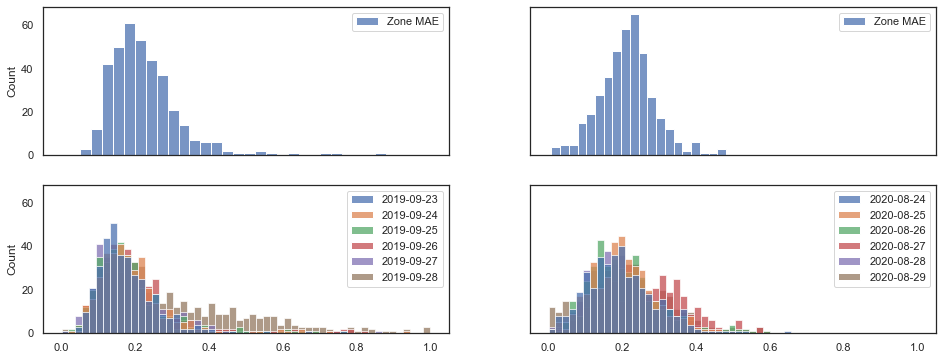

In [681]:
fig, axes = plt.subplots(2, 2, figsize=(16, 6), sharex=True, sharey=True)
sns.histplot(pd.DataFrame(mae_sept2019.stack().groupby(level=0).mean().rename('Zone MAE')), ax=axes[0][0]);
sns.histplot(pd.DataFrame(mae_pandemic.stack().groupby(level=0).mean().rename('Zone MAE')), ax=axes[0][1]);
sns.histplot(pd.DataFrame(mae_sept2019), ax=axes[1][0]);
sns.histplot(pd.DataFrame(mae_pandemic), ax=axes[1][1]);

In [665]:
display(mae_sept2019.describe(percentiles=np.linspace(0, 1, 11)))
display(mae_pandemic.describe(percentiles=np.linspace(0, 1, 11)))

,2019-09-23,2019-09-24,2019-09-25,2019-09-26,2019-09-27,2019-09-28
count,359.000000,359.000000,358.000000,358.000000,358.000000,351.000000
mean,0.178063,0.193245,0.189436,0.200689,0.188607,0.365322
std,0.085368,0.106297,0.108805,0.125865,0.105845,0.193508
min,0.000000,0.017857,0.026786,0.005233,0.002464,0.011604
0%,0.000000,0.017857,0.026786,0.005233,0.002464,0.011604
10%,0.095167,0.095749,0.092454,0.092862,0.089803,0.159060
20%,0.115928,0.123022,0.113134,0.117979,0.108903,0.203694
30%,0.131516,0.141589,0.132657,0.136974,0.126523,0.231674
40%,0.143242,0.153846,0.150781,0.156497,0.144877,0.283075
50%,0.157013,0.172594,0.166528,0.175293,0.166199,0.327119


,2020-08-24,2020-08-25,2020-08-26,2020-08-27,2020-08-28,2020-08-29
count,403.000000,403.000000,402.000000,402.000000,404.000000,405.000000
mean,0.197815,0.205783,0.206410,0.257344,0.197981,0.208419
std,0.095263,0.086473,0.098347,0.111397,0.088647,0.114805
min,0.000000,0.002054,0.001434,0.001010,0.001887,0.000000
0%,0.000000,0.002054,0.001434,0.001010,0.001887,0.000000
10%,0.084515,0.101965,0.101966,0.120919,0.096851,0.063302
20%,0.115670,0.129341,0.129425,0.160489,0.127082,0.113823
30%,0.145438,0.157906,0.145268,0.189953,0.146414,0.142832
40%,0.166275,0.181971,0.169396,0.222864,0.167548,0.172717
50%,0.189178,0.197954,0.191093,0.246508,0.188541,0.194679


In [478]:
occupancy.loc[
    occupancy.semihour.isin(pandemic_test_semihours)
    &
    occupancy.zone_id.isin(pandemic_zones)
].shape

(67605, 17)

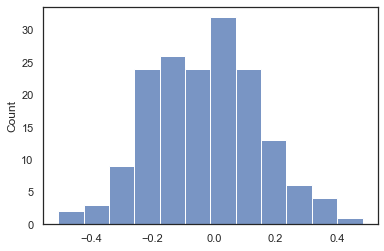

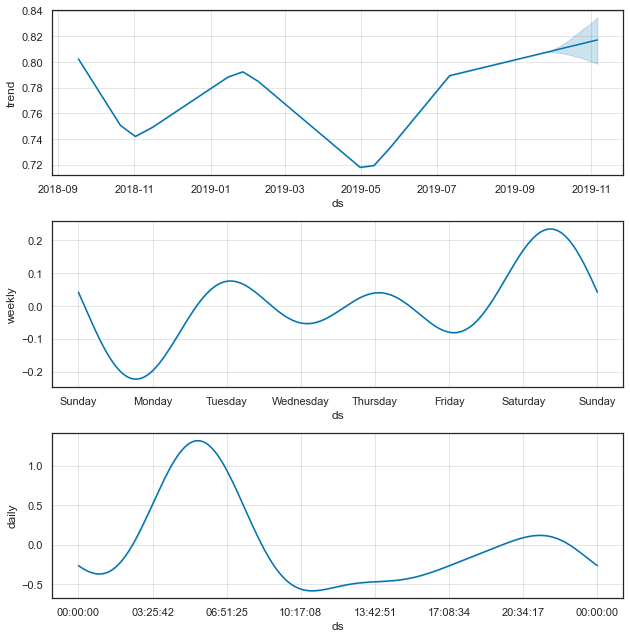

In [91]:
sns.histplot((y_test.y - forecast.set_index('ds').sort_index().yhat.clip(0, 1)).loc['2019-09-23':])
em.plot_components(forecast);

# Comparing to Ground Truth

In [73]:
meter_counts_2020_09_23_dict = pd.read_excel(
    '/Users/daniel.r.moore/Desktop/AppTesting_092320Count_Predictions.xlsx',
    sheet_name=['8am', '10am', '12pm', '2pm', '4pm', '6pm', '8pm', '10pm']
)

In [74]:
meter_counts_2020_09_23 = pd.concat([
    df.assign(time_of_day=sheet_name)
    for sheet_name, df in meter_counts_2020_09_23_dict.items()
]).rename(
    columns={'Mobile Pay Zone': 'zone_id', 'Percent Available': 'y_gt'}
)

In [92]:
meter_counts_2020_09_23['ds'] = (
    (meter_counts_2020_09_23.time_of_day.str.replace(r'^(\d+).*$', r'\1').map(int)
         + 12 * (~meter_counts_2020_09_23.time_of_day.str.contains('12')
                 & meter_counts_2020_09_23.time_of_day.str.contains('pm')))
    .map(lambda hour: pd.Timestamp(year=2020, month=9, day=23, hour=hour))
)

In [185]:
# Real training start date '2019-09-18'
# Two weeks prior: '2019-09-04'
occupancy = load_occupancy_dataset(remove_inactive_timeslots=True)

train, test = training_and_testing_data(occupancy, '2019-09-04')

zones_in_train = set(train.zone_id.map(str).unique())
zones_in_meter_counts = set(meter_counts_2020_09_23.zone_id.map(str).unique())

# DEBUG:
# print(zones_in_train.symmetric_difference(zones_in_meter_counts))
# print('In train but not meter counts:', zones_in_train.difference(zones_in_meter_counts))
# print('In meter counts but not train:', zones_in_meter_counts.difference(zones_in_train))
# print('Meter counts possible to test:', zones_in_meter_counts.difference(zones_in_meter_counts.difference(zones_in_train)))

assert zones_in_train.issuperset(zones_in_meter_counts)

In meter counts but not train: set()
Meter counts possible to test: {'17121', '17126', '17130', '17455', '17014', '17017', '17070', '17127', '17012', '17125', '17443', '17015', '17498', '17152', '17450', '17129', '17013', '17456', '17442', '17071', '17451'}


In [191]:
train = train.loc[train.zone_id.isin(zones_in_meter_counts)]

meter_counts_models = {}
for zone_id, zone_df in tqdm(train.groupby('zone_id'), desc='Zone', total=train.zone_id.nunique(), leave=True):
    meter_counts_models[zone_id] = Prophet()
    meter_counts_models[zone_id].fit(zone_df.rename(columns={'semihour': 'ds', 'available_rate': 'y'}))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

## Test

In [260]:
meter_counts_forecasts = {}
for zone_id, model in meter_counts_models.items():
    future = (model.make_future_dataframe(
                        periods=(14 + 1) * 48 + 1,  #  Adding 10:00 for the time being to match meter counts.
                        freq='30T',
                        include_history=False
                    )
                   .set_index('ds')
                   .between_time('08:00', '22:00')  # Adding 10:00 for the time being to match meter counts.
                   .reset_index()
                   .loc[lambda df: (df.ds.dt.dayofweek != 6) & (df.ds.dt.date != df.ds.dt.date.min())])
    assert future.size == 13 * (28 + 1)
    meter_counts_forecasts[zone_id] = model.predict(future)
    meter_counts_forecasts[zone_id][['yhat_lower', 'yhat', 'yhat_upper']] = meter_counts_forecasts[zone_id][['yhat_lower', 'yhat', 'yhat_upper']].clip(0, 1)

In [261]:
meter_counts_residuals = pd.DataFrame(
    index=pd.MultiIndex.from_product([
        meter_counts_2020_09_23.timestamp.unique(),
        zones_in_meter_counts
    ])
)

In [276]:
meter_counts_2020_09_23.reset_index()

,index,METER_ID,LOCATION,BLOCKFACE,SIDE_OF_ST,TOW_AWAY_H,HOURS_OPER,zone_id,Meters,9/24 Count,Spaces Available,y_gt,App Availability,1 month,3 month,6 month,time_of_day,timestamp,ds
0,0,EN246-EN258 (Even),BROAD ST E,FIFTH ST - YOUNG ST,North,7A-9A M-F,8A-10P,17012,7,0,7,1.000000,Green,0.7409,0.8398,0.8949,8am,2020-09-23 08:00:00,2020-09-23 08:00:00
1,1,EN274-EN318 (Even),BROAD ST E,FIFTH ST - GRANT AVE,North,7A-9A M-F,8A-10P,17013,23,0,23,1.000000,Green,0.8310,0.8562,0.9508,8am,2020-09-23 08:00:00,2020-09-23 08:00:00
2,2,EN253-EN261 (Odd),BROAD ST E,FIFTH ST - YOUNG ST,South,4P-6P M-F,8A-10P,17014,5,0,5,1.000000,Green,0.8528,0.7770,0.8647,8am,2020-09-23 08:00:00,2020-09-23 08:00:00
3,3,EN303-EN321 (Odd),BROAD ST E,FIFTH ST - SIXTH ST,South,4P-6P M-F,8A-10P,17015,10,0,10,1.000000,Green,0.7632,0.8552,0.8820,8am,2020-09-23 08:00:00,2020-09-23 08:00:00
4,4,EN401-EN423 (Odd),BROAD ST E,GRANT AVE - SIXTH ST,South,4P-6P M-F,8A-10P,17017,12,4,8,0.666667,Green,0.8343,0.8367,0.9141,8am,2020-09-23 08:00:00,2020-09-23 08:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,16,NM100-NM108 (Even),THIRD ST N,ELM ST - GAY ST,East,,8A-10P,17450,5,5,0,0.000000,NaN,0.8151,0.7872,0.8263,10pm,2020-09-23 22:00:00,2020-09-23 22:00:00
164,17,NM150-NM160 (Even),THIRD ST N,ELM ST - LONG ST,East,,8A-10P,17451,6,4,2,0.333333,NaN,0.8658,0.8056,0.7889,10pm,2020-09-23 22:00:00,2020-09-23 22:00:00
165,18,SM2-SM12 (Even),THIRD ST S,BROAD ST - CAPITAL ST,East,,8A-10P,17455,6,0,6,1.000000,NaN,0.9977,0.9652,0.9669,10pm,2020-09-23 22:00:00,2020-09-23 22:00:00
166,19,SM50-SM82 (Even),THIRD ST S,CAPITAL ST - STATE ST,East,,8A-10P,17456,13,1,12,0.923077,NaN,0.9930,1.0000,0.9865,10pm,2020-09-23 22:00:00,2020-09-23 22:00:00


## Performance 2 Weeks Out

In [296]:
meter_counts_2020_09_23.zone_id = meter_counts_2020_09_23.zone_id.astype(str)
meter_counts_2020_09_23 = meter_counts_2020_09_23.reset_index(drop=True)

print(zone_id)
zone_meter_counts = meter_counts_2020_09_23.loc[
    meter_counts_2020_09_23.zone_id.astype(str) == zone_id
]
(pd.concat([
    zone_meter_counts.y_gt.rename(yhat_column_name)
    for yhat_column_name in ['yhat_lower', 'yhat', 'yhat_upper']
], axis='columns').reset_index(drop=True) - meter_counts_forecasts[zone_id].loc[
    lambda df: df.ds.isin(zone_meter_counts.ds),
    ['yhat_lower', 'yhat', 'yhat_upper']
].reset_index(drop=True)).rename(columns=dict(zip(['yhat_lower', 'yhat', 'yhat_upper'], ['res_lower', 'res', 'res_upper'])))

17498


,res_lower,res,res_upper
0,0.687099,0.309817,0.000000
1,0.303150,-0.090548,-0.454530
2,0.591758,0.215213,-0.146700
3,0.702317,0.331335,-0.063699
4,0.787856,0.403506,0.013677
5,-0.100876,-0.474504,-0.837732
6,-0.136022,-0.498845,-0.867123
7,0.122526,-0.280960,-0.600000


## Next Day Performance

In [306]:
print(zone_id)

zone_test = test[test.zone_id == zone_id]

(pd.concat([
     zone_test.available_rate.rename(yhat_column_name)
     for yhat_column_name in ['yhat_lower', 'yhat', 'yhat_upper']
 ], axis='columns').reset_index(drop=True) - meter_counts_forecasts[zone_id].loc[
     lambda df: df.ds.isin(zone_test.semihour),
     ['yhat_lower', 'yhat', 'yhat_upper']
 ].reset_index(drop=True)).rename(columns=dict(zip(['yhat_lower', 'yhat', 'yhat_upper'], ['res_lower', 'res', 'res_upper']))).set_index(zone_test.semihour)

17498


,res_lower,res,res_upper
semihour,,,
2020-09-09 08:00:00,0.036115,-0.320192,-0.600000
2020-09-09 08:30:00,0.115895,-0.259718,-0.600000
2020-09-09 09:00:00,0.204898,-0.206494,-0.556772
2020-09-09 09:30:00,0.439658,0.039419,-0.356538
2020-09-09 10:00:00,0.054934,-0.320557,-0.687908
2020-09-09 10:30:00,0.275357,-0.085080,-0.449499
2020-09-09 11:00:00,0.513124,0.145853,-0.241773
2020-09-09 11:30:00,0.745458,0.370388,-0.000063
2020-09-09 12:00:00,0.769060,0.385205,0.033413


In [263]:
def semihour_uid(timestamp):
    return timestamp.dayofweek, timestamp.hour, 30 * (timestamp.minute // 30)

meter_counts_semihour_uids = meter_counts_2020_09_23.ds.map(semihour_uid).unique()
meter_counts_forecasts[zone_id].loc[
    lambda df: df.ds.map(semihour_uid).isin(meter_counts_semihour_uids),
    ['yhat_lower', 'yhat', 'yhat_upper']
] - pd.concat([meter_counts_2020_09_23.loc[lambda df: df.zone_id == zone_id].y_gt] * 3)

/Users/daniel.r.moore/Library/Caches/pypoetry/virtualenvs/predictive-parking-J8Xdfjko-py3.8/lib/python3.8/site-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)


,yhat_lower,yhat,yhat_upper
0,NaN,NaN,NaN
4,NaN,NaN,NaN
8,NaN,NaN,NaN
12,NaN,NaN,NaN
16,NaN,NaN,NaN
20,NaN,NaN,NaN
24,NaN,NaN,NaN
28,NaN,NaN,NaN
174,NaN,NaN,NaN
178,NaN,NaN,NaN


In [198]:
for zone_id, forecast in meter_counts_forecasts.items():
    for timestamp in 
    meter_counts_residuals[(timestamp, zone_id)] = pd.DataFrame(
        meter_counts_forecasts[zone_id],
        meter_counts_2020_09_23
    )

,METER_ID,LOCATION,BLOCKFACE,SIDE_OF_ST,TOW_AWAY_H,HOURS_OPER,zone_id,Meters,9/24 Count,Spaces Available,y_gt,App Availability,1 month,3 month,6 month,time_of_day,timestamp,ds
0,EN246-EN258 (Even),BROAD ST E,FIFTH ST - YOUNG ST,North,7A-9A M-F,8A-10P,17012,7,0,7,1.000000,Green,0.7409,0.8398,0.8949,8am,2020-09-23 08:00:00,2020-09-23 08:00:00
1,EN274-EN318 (Even),BROAD ST E,FIFTH ST - GRANT AVE,North,7A-9A M-F,8A-10P,17013,23,0,23,1.000000,Green,0.8310,0.8562,0.9508,8am,2020-09-23 08:00:00,2020-09-23 08:00:00
2,EN253-EN261 (Odd),BROAD ST E,FIFTH ST - YOUNG ST,South,4P-6P M-F,8A-10P,17014,5,0,5,1.000000,Green,0.8528,0.7770,0.8647,8am,2020-09-23 08:00:00,2020-09-23 08:00:00
3,EN303-EN321 (Odd),BROAD ST E,FIFTH ST - SIXTH ST,South,4P-6P M-F,8A-10P,17015,10,0,10,1.000000,Green,0.7632,0.8552,0.8820,8am,2020-09-23 08:00:00,2020-09-23 08:00:00
4,EN401-EN423 (Odd),BROAD ST E,GRANT AVE - SIXTH ST,South,4P-6P M-F,8A-10P,17017,12,4,8,0.666667,Green,0.8343,0.8367,0.9141,8am,2020-09-23 08:00:00,2020-09-23 08:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16,NM100-NM108 (Even),THIRD ST N,ELM ST - GAY ST,East,,8A-10P,17450,5,5,0,0.000000,NaN,0.8151,0.7872,0.8263,10pm,2020-09-23 22:00:00,2020-09-23 22:00:00
17,NM150-NM160 (Even),THIRD ST N,ELM ST - LONG ST,East,,8A-10P,17451,6,4,2,0.333333,NaN,0.8658,0.8056,0.7889,10pm,2020-09-23 22:00:00,2020-09-23 22:00:00
18,SM2-SM12 (Even),THIRD ST S,BROAD ST - CAPITAL ST,East,,8A-10P,17455,6,0,6,1.000000,NaN,0.9977,0.9652,0.9669,10pm,2020-09-23 22:00:00,2020-09-23 22:00:00
19,SM50-SM82 (Even),THIRD ST S,CAPITAL ST - STATE ST,East,,8A-10P,17456,13,1,12,0.923077,NaN,0.9930,1.0000,0.9865,10pm,2020-09-23 22:00:00,2020-09-23 22:00:00


In [90]:
sns.histplot((y_test.y - forecast.set_index('ds').sort_index().yhat.clip(0, 1)).loc['2019-09-23':])
em.plot_components(forecast);

,METER_ID,LOCATION,BLOCKFACE,SIDE_OF_ST,TOW_AWAY_H,HOURS_OPER,zone_id,Meters,9/24 Count,Spaces Available,y_gt,App Availability,1 month,3 month,6 month,time_of_day,timestamp
0,EN246-EN258 (Even),BROAD ST E,FIFTH ST - YOUNG ST,North,7A-9A M-F,8A-10P,17012,7,0,7,1.000000,Green,0.7409,0.8398,0.8949,8am,2020-09-23 08:00:00
1,EN274-EN318 (Even),BROAD ST E,FIFTH ST - GRANT AVE,North,7A-9A M-F,8A-10P,17013,23,0,23,1.000000,Green,0.8310,0.8562,0.9508,8am,2020-09-23 08:00:00
2,EN253-EN261 (Odd),BROAD ST E,FIFTH ST - YOUNG ST,South,4P-6P M-F,8A-10P,17014,5,0,5,1.000000,Green,0.8528,0.7770,0.8647,8am,2020-09-23 08:00:00
3,EN303-EN321 (Odd),BROAD ST E,FIFTH ST - SIXTH ST,South,4P-6P M-F,8A-10P,17015,10,0,10,1.000000,Green,0.7632,0.8552,0.8820,8am,2020-09-23 08:00:00
4,EN401-EN423 (Odd),BROAD ST E,GRANT AVE - SIXTH ST,South,4P-6P M-F,8A-10P,17017,12,4,8,0.666667,Green,0.8343,0.8367,0.9141,8am,2020-09-23 08:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16,NM100-NM108 (Even),THIRD ST N,ELM ST - GAY ST,East,,8A-10P,17450,5,5,0,0.000000,NaN,0.8151,0.7872,0.8263,10pm,2020-09-23 22:00:00
17,NM150-NM160 (Even),THIRD ST N,ELM ST - LONG ST,East,,8A-10P,17451,6,4,2,0.333333,NaN,0.8658,0.8056,0.7889,10pm,2020-09-23 22:00:00
18,SM2-SM12 (Even),THIRD ST S,BROAD ST - CAPITAL ST,East,,8A-10P,17455,6,0,6,1.000000,NaN,0.9977,0.9652,0.9669,10pm,2020-09-23 22:00:00
19,SM50-SM82 (Even),THIRD ST S,CAPITAL ST - STATE ST,East,,8A-10P,17456,13,1,12,0.923077,NaN,0.9930,1.0000,0.9865,10pm,2020-09-23 22:00:00
